In this project sentiment analysis is done using two techniques:
1. VADER - Bag of words approach
2. Roberta pretrained Model form
3. Higgingface Pipeline
   

# Step 0 - Read the data and NLTK Basics


In [235]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk
nltk.data.path.append("/kaggle/working/nltk_data")

In [236]:
df = pd.read_csv('/kaggle/input/amazon-fine-food-reviews/Reviews.csv')


In [237]:
df = df.head(500)

In [238]:
df['Text'].values[0]

'I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.'

In [239]:
print(df.shape)

(500, 10)


## EDA


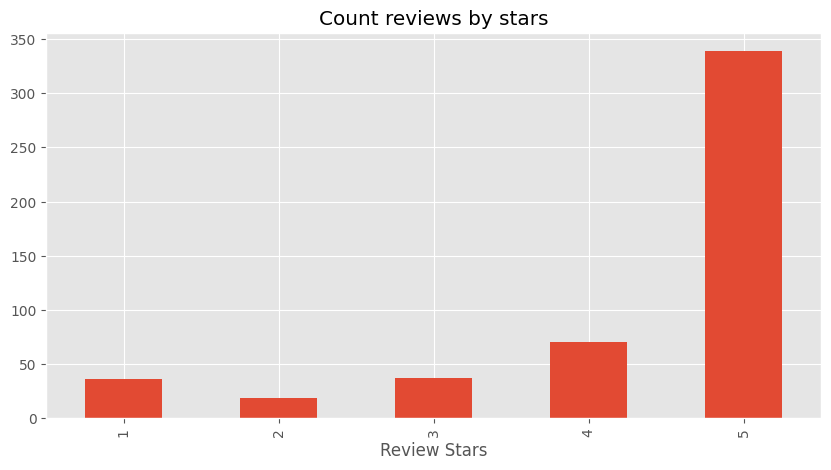

In [241]:
ax = df['Score'].value_counts().sort_index()\
    .plot(kind = 'bar', 
          title = 'Count reviews by stars', 
          figsize = (10,5))

ax.set_xlabel('Review Stars')
plt.show()

## NLTK

In [242]:
example = df['Text'][50]
print(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


In [243]:
tokens = nltk.word_tokenize(example)
tokens[:10]

['This', 'oatmeal', 'is', 'not', 'good', '.', 'Its', 'mushy', ',', 'soft']

In [244]:
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('This', 'DT'),
 ('oatmeal', 'NN'),
 ('is', 'VBZ'),
 ('not', 'RB'),
 ('good', 'JJ'),
 ('.', '.'),
 ('Its', 'PRP$'),
 ('mushy', 'NN'),
 (',', ','),
 ('soft', 'JJ')]

In [245]:
nltk.download('maxent_ne_chunker_tab')
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

[nltk_data] Downloading package maxent_ne_chunker_tab to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package maxent_ne_chunker_tab is already up-to-date!


(S
  This/DT
  oatmeal/NN
  is/VBZ
  not/RB
  good/JJ
  ./.
  Its/PRP$
  mushy/NN
  ,/,
  soft/JJ
  ,/,
  I/PRP
  do/VBP
  n't/RB
  like/VB
  it/PRP
  ./.
  (ORGANIZATION Quaker/NNP Oats/NNPS)
  is/VBZ
  the/DT
  way/NN
  to/TO
  go/VB
  ./.)


# Step 1. VADER Sentiment Scoring 
### Use Nltk Sentiment analyser to get scores of the text
#### This uses bag of words approach:
#### 1. Stop words are removed.
#### 2. Each word is scored and combined to a total score.

In [246]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

In [247]:
sia.polarity_scores('I am so happy')

{'neg': 0.0, 'neu': 0.334, 'pos': 0.666, 'compound': 0.6115}

In [248]:
sia.polarity_scores('This is the worst think ever.')

{'neg': 0.451, 'neu': 0.549, 'pos': 0.0, 'compound': -0.6249}

In [249]:
sia.polarity_scores('example')

{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

In [250]:
# Run polarity on the entire dataset
res = {}
for i, row in tqdm(df.iterrows(), total = len(df)):
    text = row['Text']
    myid = row['Id']
    res[myid] = sia.polarity_scores(text)
    

  0%|          | 0/500 [00:00<?, ?it/s]

In [251]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns = {'index': 'Id'})
vaders = vaders.merge(df, how='left')

In [252]:
# Sentiment score and metadata
vaders.head()

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


# Plot vader results

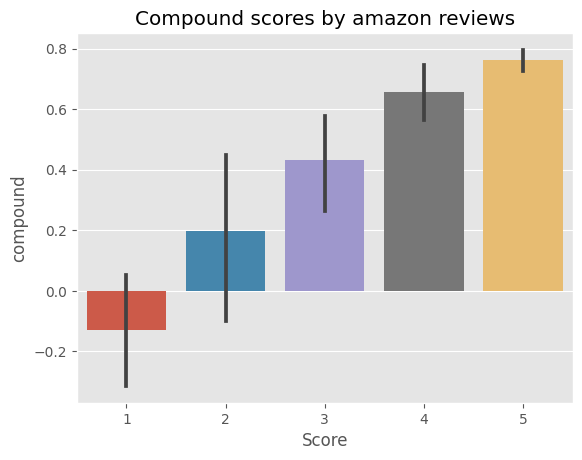

In [253]:
ax = sns.barplot(data=vaders, x = 'Score', y='compound')
ax.set_title('Compound scores by amazon reviews')
plt.show()

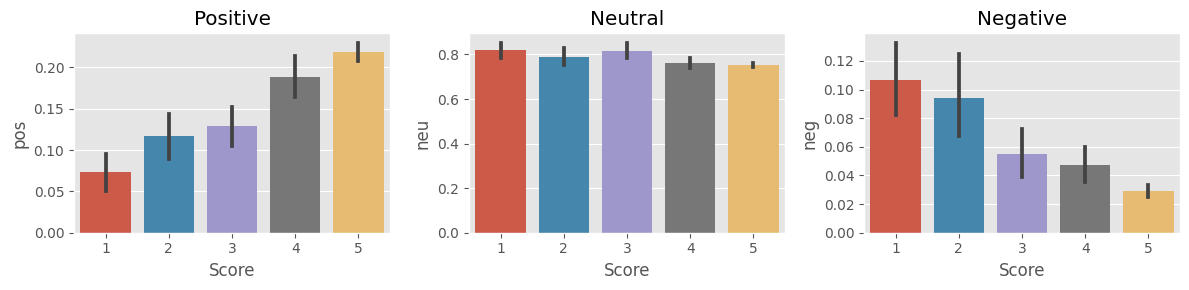

In [254]:
gig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x = 'Score', y = 'pos', ax = axs[0])
sns.barplot(data=vaders, x = 'Score', y = 'neu', ax = axs[1])
sns.barplot(data=vaders, x = 'Score', y = 'neg', ax = axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

# Step 3. Roberta Pretrained model
## Use a model to train a large corpus of data.
## Transformer model accounts for the workds but also the context related to other words.

In [255]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [256]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [257]:
# Vader results of example
print(example)
sia.polarity_scores(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [258]:
# Run for roberta model
encoded_text = tokenizer(example, return_tensors = 'pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg':scores[0],
    'roberta_neu':scores[1],
    'roberta_pos':scores[2],
}
print(scores_dict)

{'roberta_neg': 0.97635514, 'roberta_neu': 0.020687463, 'roberta_pos': 0.0029573694}


In [259]:
def polarity_scores_roberta(example):
    # Run for roberta model
    encoded_text = tokenizer(example, return_tensors = 'pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg':scores[0],
        'roberta_neu':scores[1],
        'roberta_pos':scores[2],
    }
    return scores_dict

In [260]:
# Run polarity on the entire dataset
res = {}
for i, row in tqdm(df.iterrows(), total = len(df)):
    try: 
        text = row['Text']
        myid = row['Id']
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result, **roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')

  0%|          | 0/500 [00:00<?, ?it/s]

Broke for id 83
Broke for id 187


In [261]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns = {'index': 'Id'})
results_df = results_df.merge(df, how='left')

In [262]:
results_df.head()

,Id,neg,neu,pos,compound,roberta_neg,roberta_neu,roberta_pos,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,0.009624,0.049980,0.940395,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,0.508986,0.452414,0.038600,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,0.003229,0.098067,0.898704,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,0.002295,0.090219,0.907486,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,0.001635,0.010302,0.988063,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [263]:
results_df.columns

Index(['Id', 'neg', 'neu', 'pos', 'compound', 'roberta_neg', 'roberta_neu',
       'roberta_pos', 'ProductId', 'UserId', 'ProfileName',
       'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time',
       'Summary', 'Text'],
      dtype='object')

## Compare scores between models

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

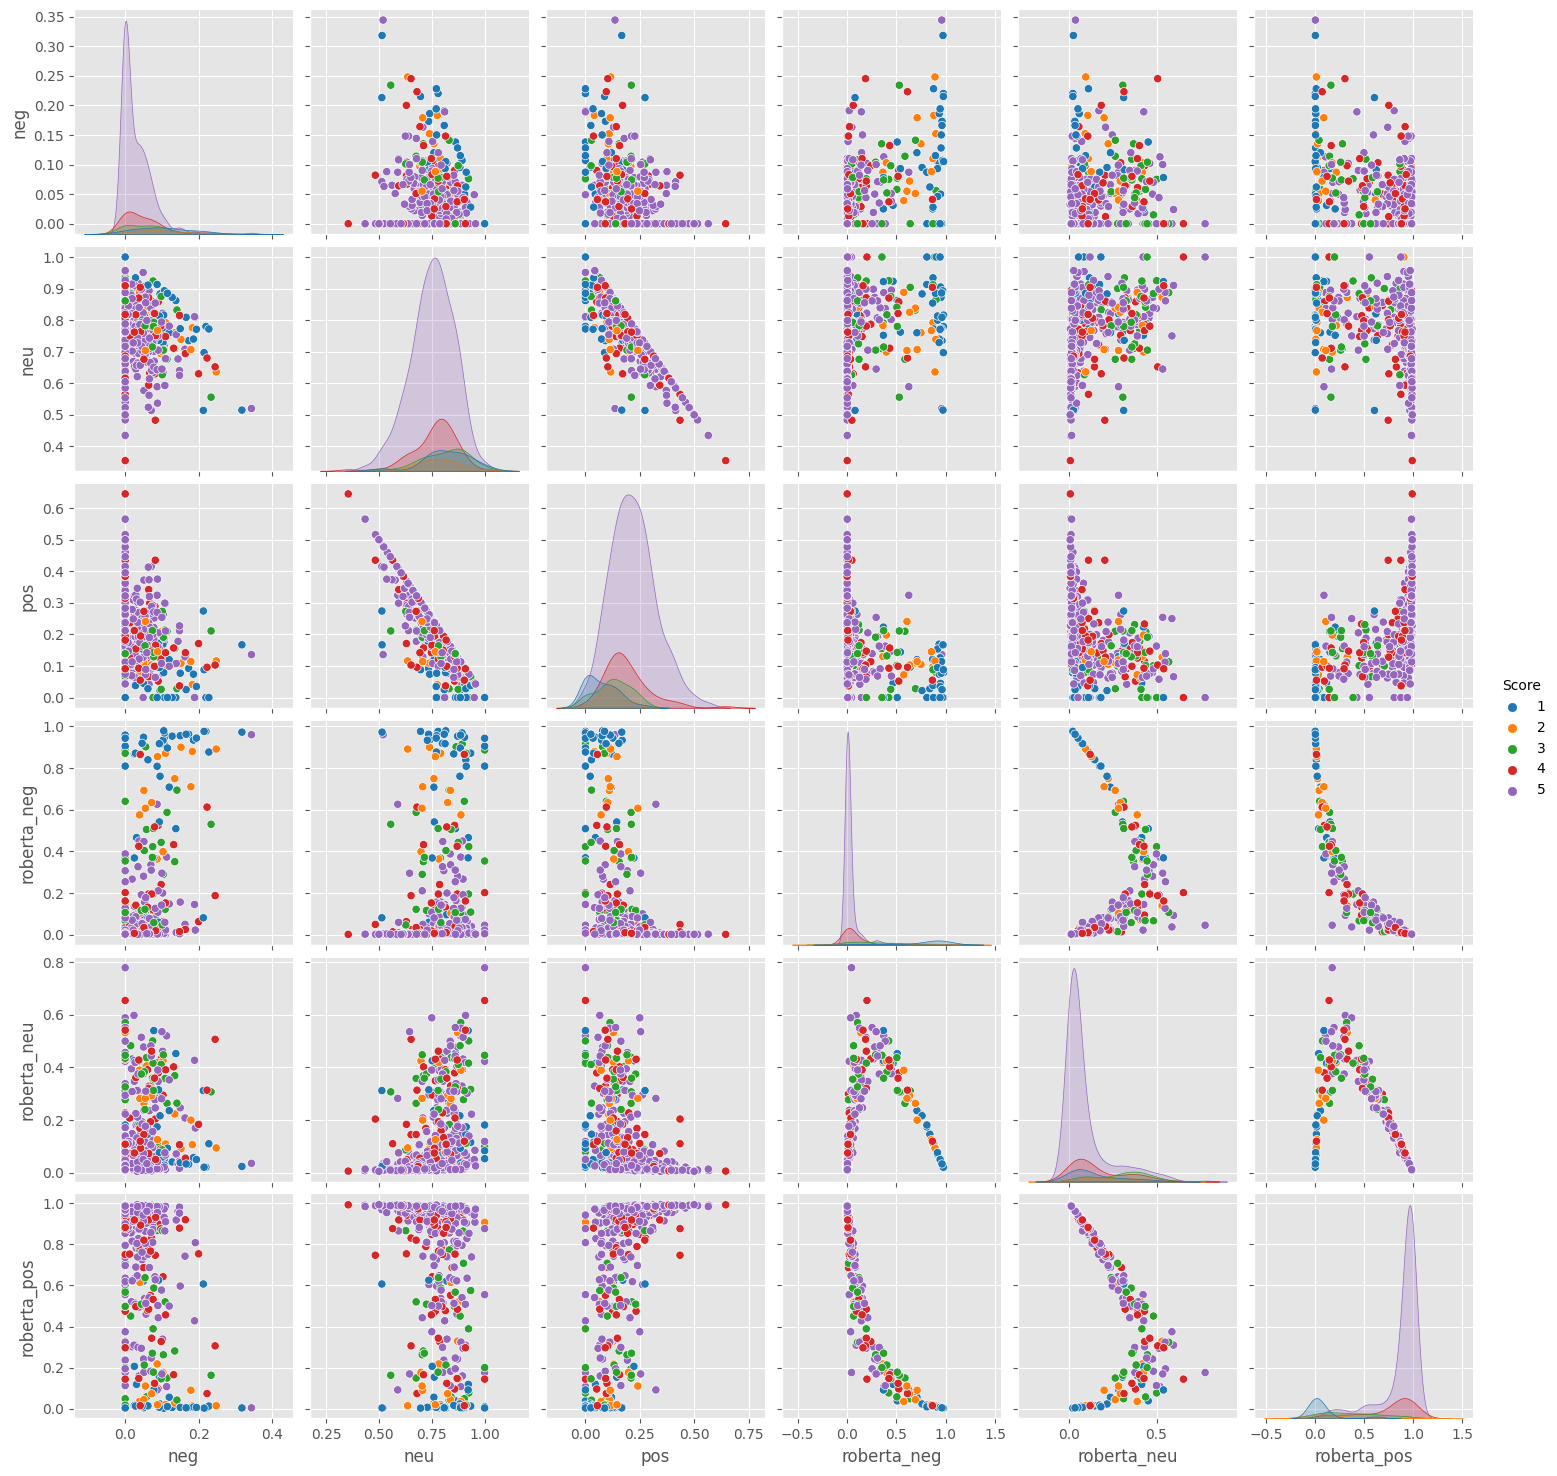

In [267]:
sns.pairplot(data=results_df, 
             vars = ['neg', 'neu', 'pos', 
                     'roberta_neg', 'roberta_neu','roberta_pos'],
             hue = 'Score',
             palette = 'tab10')
plt.show()

# Step 4 - Review Examples
### Positive 1-Star and Negative 5-Star reviews
#### Examples where the mdel scores and the review score differ the mose

In [268]:
results_df.query('Score == 1')\
.sort_values('roberta_pos', ascending = False)['Text'].values[0]

'I felt energized within five minutes, but it lasted for about 45 minutes. I paid $3.99 for this drink. I could have just drunk a cup of coffee and saved my money.'

In [269]:
results_df.query('Score == 1')\
    .sort_values('pos', ascending = False)['Text'].values[0]

'So we cancelled the order.  It was cancelled without any problem.  That is a positive note...'

In [ ]:
# Negative sentiment 5-star review


In [270]:
results_df.query('Score == 5')\
.sort_values('roberta_neg', ascending = False)['Text'].values[0]

'this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault'

In [272]:
results_df.query('Score == 5')\
.sort_values('neg', ascending = False)['Text'].values[0]

'this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault'

## Hugging face transformers pipeline

In [274]:
from transformers import pipeline
sent_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cpu


In [275]:
sent_pipeline('I love sentiment analysis')

[{'label': 'POSITIVE', 'score': 0.999736487865448}]

In [277]:
sent_pipeline('boo')

[{'label': 'NEGATIVE', 'score': 0.9715902209281921}]